In [1]:
import pandas as pd

## load in People Recurrence Data

path_input_people = '/Users/srilakshmi/Desktop/Thesis/04-Data-Analysis-Results/00-Data-Sources/00-Cloud-to-Street/01-District-level/People/Output/'
name_input_file_people = 'District_Flood_Risk_Classification_People.csv'

## load in Cropland Recurrence Data

path_input_crops = '/Users/srilakshmi/Desktop/Thesis/04-Data-Analysis-Results/00-Data-Sources/00-Cloud-to-Street/01-District-level/Crops/Output/'
name_input_file_crops = 'District_Flood_Risk_Classification_Crops.csv'

## load in Flooded Area Recurrence Data

path_input_flooded_area = '/Users/srilakshmi/Desktop/Thesis/04-Data-Analysis-Results/00-Data-Sources/00-Cloud-to-Street/01-District-level/Flooded-Area/Output/'
name_input_file_flooded_area = 'District_Flood_Risk_Classification_Flooded-Area.csv'

## load in Markets Recurrence Data

path_input_markets = '/Users/srilakshmi/Desktop/Thesis/04-Data-Analysis-Results/00-Data-Sources/00-Cloud-to-Street/01-District-level/Markets/Output/'
name_input_file_markets = 'District_Flood_Risk_Classification_Markets.csv'

## load in Roads Recurrence Data

path_input_roads = '/Users/srilakshmi/Desktop/Thesis/04-Data-Analysis-Results/00-Data-Sources/00-Cloud-to-Street/01-District-level/Roads/Output/'
name_input_file_roads = 'District_Flood_Risk_Classification_Roads.csv'

## output files
path_output = '/Users/srilakshmi/Desktop/Thesis/04-Data-Analysis-Results/01-TC-Assignment/'
name_output_file = 'Adm2_TC_Assignment_Recurrence.csv'


In [2]:
# get avg impact per recurrence data at district level ---

people = pd.read_csv(path_input_people+name_input_file_people, header=0)
crops = pd.read_csv(path_input_crops+name_input_file_crops, header=0)
flooded_area = pd.read_csv(path_input_flooded_area+name_input_file_flooded_area, header=0)
markets = pd.read_csv(path_input_markets+name_input_file_markets, header=0)
roads = pd.read_csv(path_input_roads+name_input_file_roads, header=0)

tot_flood_risk = people.merge(crops, on='Region')
tot_flood_risk = tot_flood_risk.merge(flooded_area, on='Region')
tot_flood_risk = tot_flood_risk.merge(markets, on='Region')
tot_flood_risk = tot_flood_risk.merge(roads, on='Region')


In [3]:
import numpy as np

# ASSUMPTIONS -----------------

treatment_control_cutoff = 0.45 # percentile threshold above which districts belong to treatment group

cropland_weights = 1
people_weights = 1
flooded_area_weights = 1
markets_weights = 1
roads_weights = 1

print('Treatment cutoff assigned: Districts in the', str(int(treatment_control_cutoff*100))+'th percentile and above w.r.t. total flood risk')
print('Weights assigned - cropland: ', str(cropland_weights))
print('Weights assigned - people: ', str(people_weights))
print('Weights assigned - flooded area: ', str(flooded_area_weights))
print('Weights assigned - markets: ', str(markets_weights))
print('Weights assigned - roads: ', str(roads_weights))

#assert cropland_weights+people_weights+flooded_area_weights+markets_weights+roads_weights == 1

# apply arbitrary risk formula ----------------

tot_flood_risk['Risk'] = pd.Series((np.array(tot_flood_risk['Avg Impact Per Year - People']) * people_weights) + 
                                   (np.array(tot_flood_risk['Avg Impact Per Year - Crops']) * cropland_weights) +
                                   (np.array(tot_flood_risk['Avg Impact Per Year - Flooded Area']) * flooded_area_weights) +
                                  (np.array(tot_flood_risk['Avg Impact Per Year - Roads']) * roads_weights) +
                                  (np.array(tot_flood_risk['Avg Impact Per Year - Markets']) * markets_weights))

tot_flood_risk = tot_flood_risk.sort_values(by='Risk', ascending=False)

# generate boolean treatment-control assignment variable to use moving forward ----

tot_flood_risk['Treatment'] = None
n_treatment = round(len(tot_flood_risk) * treatment_control_cutoff)
tot_flood_risk.loc[tot_flood_risk.index[0:n_treatment], 'Treatment'] = 1
tot_flood_risk.loc[tot_flood_risk.index[n_treatment:len(tot_flood_risk)], 'Treatment'] = 0

# assert to ensure all districts were assigned to treatment vs control
assert tot_flood_risk.groupby('Treatment').size()[0]+tot_flood_risk.groupby('Treatment').size()[1] == len(tot_flood_risk)
print(tot_flood_risk.groupby('Treatment').size())

Treatment cutoff assigned: Districts in the 45th percentile and above w.r.t. total flood risk
Weights assigned - cropland:  1
Weights assigned - people:  1
Weights assigned - flooded area:  1
Weights assigned - markets:  1
Weights assigned - roads:  1
Treatment
0    119
1     97
dtype: int64


In [4]:
# load obs data at district level ----

path = '/Users/srilakshmi/Desktop/Thesis/04-Data-Analysis-Results/00-Data-Sources/00-Cloud-to-Street/01-District-level/Data-Observational/'
x = pd.read_csv(path+'Ghana_Stats_Rec_v2.csv')


In [5]:
df = x.merge(tot_flood_risk, left_on='admin2name', right_on='Region')
df = df[['year', 'admin2name', 'pop_sum', 'Treatment']]
df = df[df['year'] >=2015]

control = df[df['Treatment'] == 0].groupby('year', as_index=False).mean()
treatment = df[df['Treatment'] == 1].groupby('year', as_index=False).mean()


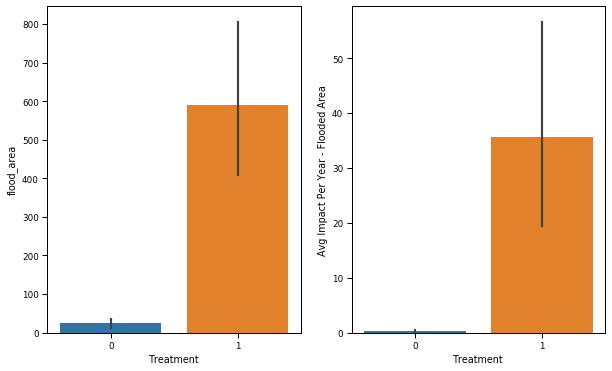

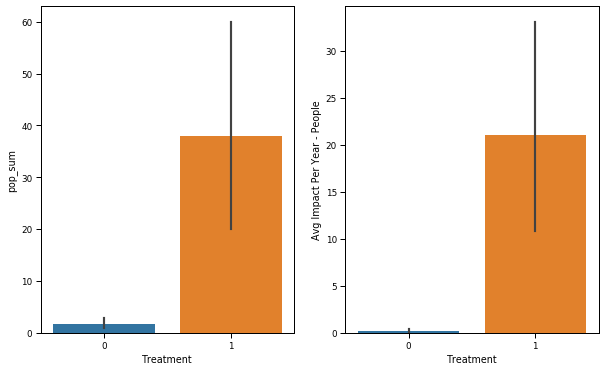

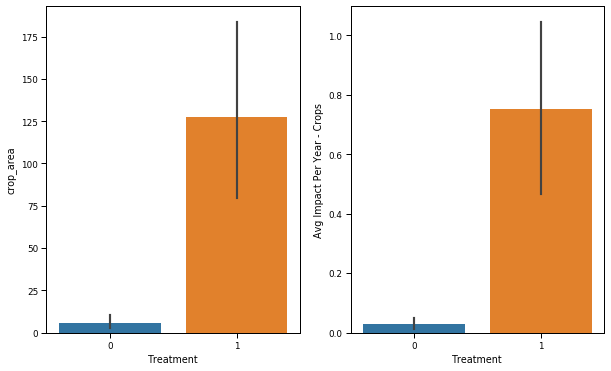

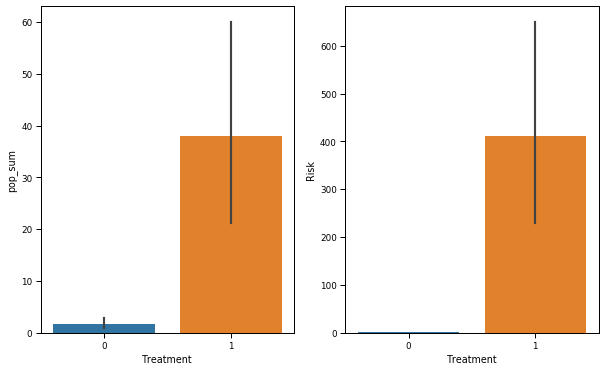

In [6]:
x = x.groupby('admin2name',as_index=False).mean()[['admin2name','crop_area','flood_area','pop_sum']]
merged = tot_flood_risk.merge(x, left_on='Region', right_on='admin2name')

import matplotlib.pyplot as plt
import seaborn as sns

# observe if parallel trends exist -----

sns.set_context("paper")

#fig, ax = plt.subplots()
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# plot treatment and control lines
sns.barplot(ax=axes[0], x = "Treatment", y = "flood_area", data = merged)
sns.barplot(ax=axes[1], x = "Treatment", y = "Avg Impact Per Year - Flooded Area", data = merged)

#fig, ax = plt.subplots()
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# plot treatment and control lines
sns.barplot(ax=axes[0], x = "Treatment", y = "pop_sum", data = merged)
sns.barplot(ax=axes[1], x = "Treatment", y = "Avg Impact Per Year - People", data = merged)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# plot treatment and control lines
sns.barplot(ax=axes[0], x = "Treatment", y = "crop_area", data = merged)
sns.barplot(ax=axes[1], x = "Treatment", y = "Avg Impact Per Year - Crops", data = merged)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# plot treatment and control lines
sns.barplot(ax=axes[0], x = "Treatment", y = "pop_sum", data = merged)
sns.barplot(ax=axes[1], x = "Treatment", y = "Risk", data = merged)
